Generating distorted characters in a variety of fonts and teaching a network to recognize them.
This application will take background patches or noise and generate random text on top of them with tuples of three letters.  The three letters let us predict 'first', 'middle', and 'last' letters so that we can chain together full words.  Transforms include affine and perspective distortions.

In [38]:
%matplotlib inline

import os, shutil
import sys
import math
import json
import random
import pickle
import string
from glob import glob

import numpy
from PIL import Image, ImageDraw, ImageFont, ImageTransform
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, ZeroPadding2D, MaxPooling2D, Flatten, Dropout, Reshape, Activation, LeakyReLU, Add, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib
import matplotlib.pyplot as plt

print(K.image_data_format()) # Should be channels_last

channels_last


## Data Generation

In [2]:
# Constants
STRING_LENGTH = 1
TEXT_SIZE = (32, 32)
IMAGE_SIZE = TEXT_SIZE # For now.  We'll want to crop out a section of an image.
FONTS_DIR = "/usr/share/fonts/truetype/"
FONT_CHOICES = glob(os.path.join(FONTS_DIR, "*", "*.ttf"))
FONT_CHOICES = ['/usr/share/fonts/truetype/freefont/FreeSans.ttf', '/usr/share/fonts/truetype/freefont/FreeSerif.ttf', '/usr/share/fonts/truetype/freefont/FreeMono.ttf']
print(FONT_CHOICES)

['/usr/share/fonts/truetype/freefont/FreeSans.ttf', '/usr/share/fonts/truetype/freefont/FreeSerif.ttf', '/usr/share/fonts/truetype/freefont/FreeMono.ttf']


In [3]:
# Crop from an image.
#base = Image.open('Pillow/Tests/images/hopper.png').convert('RGBA')
base = Image.new('RGBA', IMAGE_SIZE,(0, 0, 0, 255))

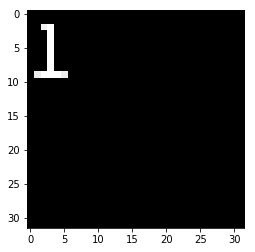

l


In [4]:
# Make a blank image for the text, initialized to transparent text color
printable_chars = [c for c in string.printable if c.isalnum()]
#printable_chars = ['a', 'b'] # DEBUG
def new_text_image(opacity=255, color=(255, 255, 255)):
    txt_image = Image.new('RGBA', TEXT_SIZE, (255,255,255,0))

    # Randomly select a font and a size.
    font_size = random.randint(12, 36)
    fnt = ImageFont.truetype(random.choice(FONT_CHOICES), font_size)

    # Get a drawing context.
    d = ImageDraw.Draw(txt_image)

    # Generate three random characters.
    target_string = "".join([random.choice(printable_chars) for _ in range(STRING_LENGTH)])

    # Full opacity, 1/nth of the way down the image, making it roughly centered.
    x_start = 0 #random.randint(0, TEXT_SIZE[0]//2)
    y_start = 0 #random.randint(0, TEXT_SIZE[1]//3)
    d.text((x_start, y_start), target_string, font=fnt, fill=(color[0], color[1], color[2], opacity)) # 255 = full opacity.
    
    return txt_image, target_string

# DEBUG SAMPLE COMPOSITE:
txt_image, target_str = new_text_image()
out_undistorted = Image.alpha_composite(base, txt_image)
#out.show()
plt.imshow(out_undistorted)
plt.show()
print(target_str)

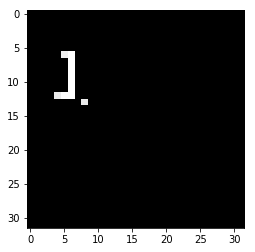

In [5]:
# Make a random transform and distort the text.
def distort_text_image(txt):
    # Upper left, lower left, lower right, upper_right.
    left_min = -10
    left_max = 0
    right_min = TEXT_SIZE[0]-2
    right_max = TEXT_SIZE[0]
    top_min = -10
    top_max = 0
    bottom_min = TEXT_SIZE[1]-2
    bottom_max = TEXT_SIZE[1]
    # Upper left
    x0 = random.randint(left_min, left_max)
    y0 = random.randint(top_min, top_max)
    # Lower left
    x1 = random.randint(left_min, left_max)
    y1 = random.randint(bottom_min, bottom_max)
    # Lower right
    x2 = random.randint(right_min, right_max)
    y2 = random.randint(bottom_min, bottom_max)
    # Upper right
    x3 = random.randint(right_min, right_max)
    y3 = random.randint(top_min, top_max)
    transform = ImageTransform.QuadTransform((x0, y0, x1, y1, x2, y2, x3, y3))
    txt_distorted = transform.transform(TEXT_SIZE, txt)
    return txt_distorted

# DEBUG: Composite
txt_distorted = distort_text_image(txt_image)
out_distorted = Image.alpha_composite(base, txt_distorted)
plt.imshow(out_distorted)
plt.show()

In [ ]:
# This is stolen from here: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# Maybe we want to replace our data augmentation with this method?
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

###

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

## Model Creation

In [6]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        tf.summary.scalar('mean', tf.reduce_mean(var))
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

#def summary(y_true, y_pred):
#    return tf.summary.merge_all()
#model.compile(optimizer=Adagrad(), loss=loss_dict, metrics=[summary])

#summary_writer = tf.summary.FileWriter("logs/" + args.name)

#l = value_policy_model.train_on_batch(x_batch, y_batch)
#l_dict = dict(zip(value_policy_model.metrics_names, l))
#summary_writer.add_summary(l_dict['value_summary'], global_step=iter_idx)
#summary_writer.flush()

In [61]:
K.clear_session()

inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

def get_padding(desired_shape, current_shape):
    # Input: a 4-element list with the [B, H, W, D] values of the shapes.
    # Returns a padding of two tuples ((top_pad, bottom_pad), (left_pad, right_pad)).
    # Compatible with ZeroPadding2D.  Keeps target shape in center.
    # |-r-|--bw-|-s-|
    # |-----aw------|
    # aw = bw + r + s.
    # aw = desired shape[2].  bw = current_shape[2].  r = left_pad s = right_pad
    leftover_space = desired_shape[1] - current_shape[1]
    top_pad = leftover_space//2
    bottom_pad = leftover_space - top_pad # Do this because //2 is int division.
    leftover_space = desired_shape[2] - current_shape[2]
    left_pad = leftover_space//2
    right_pad = leftover_space - left_pad
    return ((top_pad, bottom_pad), (left_pad, right_pad))

def model_block(x_in, scope_name, filter_count):
    with tf.name_scope(scope_name): # Name scope instead of variable_scope because we don't want reuse here.
        #x_tiny = Flatten()(x_tiny)
        #x_tiny.set_shape([None, x_tiny_shape[1]*x_tiny_shape[2]*x_tiny_shape[3]])

        x_small = Conv2D(filters=filter_count, kernel_size=(3,3), strides=(2,2), padding='same')(x_in)
        x_small = LeakyReLU()(x_small)
        x_small_shape = K.int_shape(x_small)
        # We need to zero-pad x_small so it fits on top of x_tiny.
        #x_small = ZeroPadding2D(padding=get_padding(x_tiny_shape, x_small_shape), data_format="channels_last")(x_small)

        x_med = Conv2D(filters=filter_count, kernel_size=(5,5), strides=(3,3), padding='same')(x_in)
        x_med = LeakyReLU()(x_med)
        x_med_shape = K.int_shape(x_med)
        x_med = ZeroPadding2D(padding=get_padding(x_small_shape, x_med_shape), data_format="channels_last")(x_med)

        x_large = Conv2D(filters=filter_count, kernel_size=(7,7), strides=(3,3), padding='same')(x_in)
        x_large = LeakyReLU()(x_large)
        x_large_shape = K.int_shape(x_large)
        x_large = ZeroPadding2D(padding=get_padding(x_small_shape, x_large_shape), data_format="channels_last")(x_large)

        #x_max = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x_in)
        #x_max = Flatten()(x_max)

        #joint = Concatenate()([x_tiny, x_small, x_big, x_huge])
        #joint_shape = [None, K.int_shape(x_tiny)[1]*K.int_shape(x_small)[1]*K.int_shape(x_big)[1]*K.int_shape(x_huge)[1]]
        #block = Reshape((x_in_shape[1], x_in_shape[2], 4*filter_count))(joint)
        #block = Reshape((int(math.sqrt(joint_shape[1])), int(math.sqrt(joint_shape[1])), 1))(joint)
        #print(x_huge.get_shape().as_list())
        
        #block = K.stack([x_tiny, x_small, x_big, x_huge], axis=3)
        block = Concatenate(axis=3)([x_small, x_med, x_large])
        
        out = Conv2D(filters=filter_count, kernel_size=(1,1), strides=(1,1), padding='same')(block)
    
    return out

x = inputs

x = model_block(x, "block0", 16)
x = BatchNormalization()(x)
x = model_block(x, "block1", 32)
x = BatchNormalization()(x)
x = model_block(x, "block2", 64)
x = BatchNormalization()(x)

x_flat = Flatten()(x)
x = x_flat

# Dense tunnel.
with tf.name_scope("dense_pipe"):
    x = Dense(1024)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    variable_summaries(x)

    x = Dense(1024)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    variable_summaries(x)
    
    x = Dense(1024)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    variable_summaries(x)

x = Dense(STRING_LENGTH*(ord('~')+1))(x)
x = Reshape((STRING_LENGTH, 1+ord('~')))(x)
predictions = Activation('softmax')(x)
#variable_summaries(x)

model = Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adadelta(lr=1.0, rho=0.95, decay=0.0)
model.compile(optimizer=opt, loss='categorical_crossentropy')

print(model.count_params())
print(model.summary())

3524751
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 11, 11, 16)    1216        input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 11, 11, 16)    2368        input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 16, 16, 16)    448         input_1[0][0]                    
___________________________________________________________________________________

## Train

In [8]:
def generator(base_image_selector, batch_size, enable_distortion):
    image_files = glob(base_image_selector)
    batch = numpy.zeros((batch_size, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=numpy.uint8)
    labels = numpy.zeros((batch_size, STRING_LENGTH, ord('~')+1), dtype=numpy.uint8)
    while True:
        # Load an image.
        base_filename = random.choice(image_files)
        img = Image.open(base_filename).convert('RGBA')
        #img = Image.new('RGBA', IMAGE_SIZE) # DEBUG
        for i in range(batch_size):
            # Cut out a section of it.
            x = random.randint(0, img.size[0]-IMAGE_SIZE[0])
            y = random.randint(0, img.size[1]-IMAGE_SIZE[1])
            right = x+IMAGE_SIZE[0]
            bottom = y+IMAGE_SIZE[1]
            region = img.crop((x, y, right, bottom))
            # Select the average color of this region so we can pick a random color that avoids it.
            average_color = [0, 0, 0]
            num_pixels = IMAGE_SIZE[0]*IMAGE_SIZE[1]
            for y in range(0, IMAGE_SIZE[1]):
                for x in range(0, IMAGE_SIZE[0]):
                    pix = region.getpixel((x, y))
                    average_color[0] += pix[0]
                    average_color[1] += pix[1]
                    average_color[2] += pix[2]
            average_color[0] = int(average_color[0]/num_pixels)
            average_color[1] = int(average_color[1]/num_pixels)
            average_color[2] = int(average_color[2]/num_pixels)
            # Select a color that is very high contrast.
            r = random.randint(average_color[0] + 50, average_color[0] + 150)%255 # Wrap around.
            g = random.randint(average_color[1] + 50, average_color[1] + 150)%255 # Wrap around.
            b = random.randint(average_color[2] + 50, average_color[2] + 150)%255 # Wrap around.
            # Produce a random text image and the matching characters.
            text_image, text_string = new_text_image(opacity=random.randint(230, 255), color=(r, g, b))
            # Distort the text image, maybe.
            if enable_distortion and random.choice((True, False)):
                text_image = distort_text_image(text_image)
            # Superimpose the text on the image.
            out = Image.alpha_composite(region, text_image)
            example = numpy.asarray(out.convert('RGB'))
            # Convert our text into an array of size 3x128
            label = numpy.zeros(shape=(STRING_LENGTH, ord('~')+1), dtype=numpy.uint8)
            for j in range(STRING_LENGTH):
                label[j][ord(text_string[j])] = 1
            # Return our training + label pair
            batch[i,:,:,:] = example[:,:,:]
            labels[i,:,:] = label[:,:]
        yield batch/255.0, labels

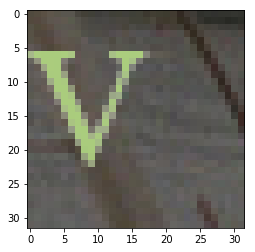

V
(1000, 1, 127)
[[ 0.31372549  0.32941176  0.35294118  0.36862745  0.34901961]
 [ 0.3254902   0.33333333  0.34117647  0.36470588  0.37254902]
 [ 0.33333333  0.31764706  0.34117647  0.35686275  0.35686275]
 [ 0.34117647  0.31764706  0.31764706  0.3254902   0.36470588]
 [ 0.3372549   0.34117647  0.32941176  0.3372549   0.37254902]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


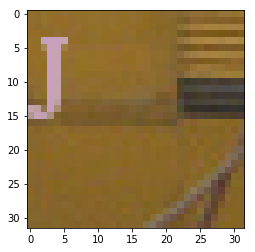

J
(1000, 1, 127)
[[ 0.56862745  0.55686275  0.56862745  0.56862745  0.57647059]
 [ 0.56862745  0.55686275  0.57647059  0.58039216  0.58823529]
 [ 0.57647059  0.55294118  0.56470588  0.57254902  0.58039216]
 [ 0.57254902  0.58431373  0.56862745  0.56078431  0.57254902]
 [ 0.57254902  0.56862745  0.78431373  0.78431373  0.78431373]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


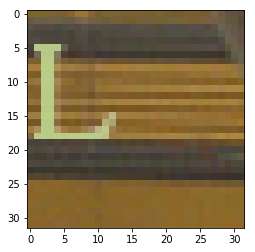

L
(1000, 1, 127)
[[ 0.4745098   0.48235294  0.47843137  0.48235294  0.48235294]
 [ 0.40784314  0.41568627  0.41176471  0.43921569  0.42352941]
 [ 0.33333333  0.32941176  0.32941176  0.31764706  0.29019608]
 [ 0.29803922  0.28627451  0.28627451  0.28235294  0.27058824]
 [ 0.3254902   0.32941176  0.30588235  0.30196078  0.29019608]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


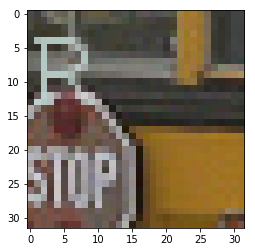

R
(1000, 1, 127)
[[ 0.28235294  0.24313725  0.39215686  0.48627451  0.42352941]
 [ 0.29019608  0.25882353  0.27058824  0.38431373  0.47843137]
 [ 0.29803922  0.23529412  0.25098039  0.23921569  0.23137255]
 [ 0.22352941  0.21568627  0.22352941  0.23529412  0.23921569]
 [ 0.21568627  0.66666667  0.69411765  0.69803922  0.69411765]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


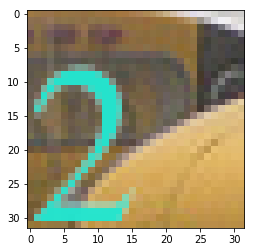

2
(1000, 1, 127)
[[ 0.61960784  0.59607843  0.59607843  0.6         0.58431373]
 [ 0.54901961  0.54117647  0.55686275  0.58431373  0.54117647]
 [ 0.53333333  0.53333333  0.51372549  0.51764706  0.45490196]
 [ 0.43137255  0.5254902   0.4745098   0.45490196  0.39607843]
 [ 0.43921569  0.51372549  0.46666667  0.43529412  0.34901961]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


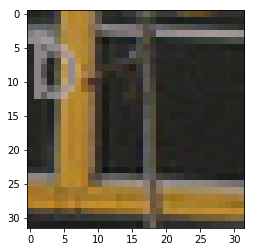

b
(1000, 1, 127)
[[ 0.1254902   0.13333333  0.16862745  0.16470588  0.27058824]
 [ 0.17647059  0.17254902  0.18823529  0.19215686  0.28235294]
 [ 0.36862745  0.37647059  0.37647059  0.36862745  0.39215686]
 [ 0.50980392  0.58039216  0.54117647  0.47058824  0.41960784]
 [ 0.55686275  0.58431373  0.62352941  0.61960784  0.48235294]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


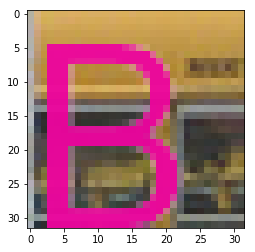

B
(1000, 1, 127)
[[ 0.70196078  0.84705882  0.84313725  0.83529412  0.85098039]
 [ 0.70588235  0.83529412  0.82745098  0.82352941  0.83921569]
 [ 0.70980392  0.82352941  0.81568627  0.81176471  0.81960784]
 [ 0.70588235  0.8         0.78823529  0.78431373  0.79215686]
 [ 0.69803922  0.77254902  0.76470588  0.76862745  0.78823529]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


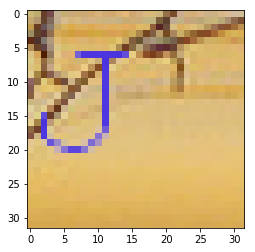

J
(1000, 1, 127)
[[ 0.79607843  0.74117647  0.40392157  0.45882353  0.76470588]
 [ 0.77254902  0.70196078  0.38823529  0.50196078  0.75686275]
 [ 0.75294118  0.40784314  0.40784314  0.5372549   0.77254902]
 [ 0.60784314  0.37254902  0.36470588  0.56862745  0.83137255]
 [ 0.37254902  0.30980392  0.50196078  0.69803922  0.87058824]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


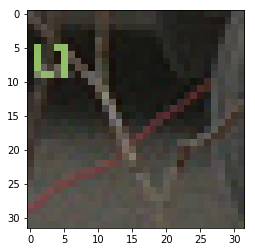

u
(1000, 1, 127)
[[ 0.34117647  0.24705882  0.20392157  0.26666667  0.2627451 ]
 [ 0.3254902   0.33333333  0.19607843  0.25490196  0.23529412]
 [ 0.15294118  0.26666667  0.3372549   0.2627451   0.22745098]
 [ 0.10196078  0.14901961  0.29019608  0.30980392  0.19215686]
 [ 0.10196078  0.08627451  0.14901961  0.26666667  0.21960784]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


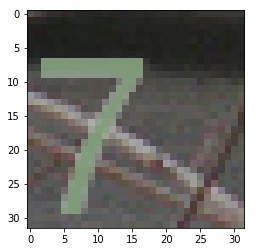

7
(1000, 1, 127)
[[ 0.3254902   0.28627451  0.24705882  0.19607843  0.19607843]
 [ 0.17254902  0.17254902  0.16470588  0.13333333  0.12941176]
 [ 0.11372549  0.1254902   0.11764706  0.11372549  0.11372549]
 [ 0.1372549   0.13333333  0.12941176  0.1372549   0.1254902 ]
 [ 0.11764706  0.11764706  0.11764706  0.11372549  0.1254902 ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [65]:
batch_size = 1000
gen = generator("./train2014/*.jpg", batch_size=batch_size, enable_distortion=False)
x, y = next(gen)
for i in range(0, min(10, x.shape[0])):
    plt.imshow(Image.fromarray((x[i,:,:,:]*255).astype(numpy.uint8)))
    plt.show()
    print(chr(numpy.argmax(y[i][0])))
    print(y.shape)
    print(x[i,:5,:5,0])
    print(y[i,:])

In [ ]:
shutil.rmtree("/tmp/logs_tboard/")
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1) # save_best_only=True
tb = TensorBoard(log_dir='/tmp/logs_tboard', histogram_freq=0, batch_size=10, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# Add `callbacks=[tb, checkpointer]` to train to use these.
# Run TB with `tensorboard --logdir=/full_path_to_your_logs`

epochs = 1000
steps_per_epoch = 10
#performance = 0
#for _ in range(steps_per_epoch): # Steps per epoch
#    x, y = next(gen)
#    performance += model.train_on_batch(x, y)
#performance /= steps_per_epoch
#print("Epoch {}: {}".format(i, performance))
hist = model.fit_generator(gen, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=[checkpointer, tb]) # Yield 1000 batches of 10 items from generator per epoch.

print("Checkpointing.  Saving model.")
model.save("ocr.h5")
# These are no longer necessary with our callbacks.
ignore = """
fout = open("/tmp/log_status_meta_epoch_{}.log".format(i), 'wt')
pickle.dump(hist, fout, -1)
fout.close()
"""

Epoch 1/1000
10/10 [==============================] - 25s - loss: 5.4975    
Epoch 2/1000
10/10 [==============================] - 23s - loss: 5.0244    
Epoch 3/1000
10/10 [==============================] - 23s - loss: 4.5499    
Epoch 4/1000
10/10 [==============================] - 23s - loss: 4.0817    
Epoch 5/1000
10/10 [==============================] - 23s - loss: 3.8653    
Epoch 6/1000
10/10 [==============================] - 23s - loss: 3.4865    
Epoch 7/1000
10/10 [==============================] - 23s - loss: 3.5935    
Epoch 8/1000
10/10 [==============================] - 24s - loss: 3.2724    
Epoch 9/1000
10/10 [==============================] - 23s - loss: 3.1116    
Epoch 10/1000
10/10 [==============================] - 23s - loss: 3.0402    
Epoch 11/1000
10/10 [==============================] - 23s - loss: 2.7052    
Epoch 12/1000
10/10 [==============================] - 23s - loss: 2.8357    
Epoch 13/1000
10/10 [==============================] - 24s - loss: 2.5873

In [ ]:
model.save("ocr.h5")
#model.predict(x[:,:,:])

# Visualize model performance on some examples.
x, y = next(gen)
prediction = model.predict(x)
for i in range(x.shape[0]):
    plt.imshow(Image.fromarray((x[i,:,:,:]*255).astype(numpy.uint8)))
    plt.show()
    print("Character guesses:")
    guess_indices = numpy.argpartition(prediction[i,0,:], -5)[-5:]
    for ind in guess_indices:
        c = chr(ind)
        print("{} : {}".format(c, prediction[i,0,ind]))
    print("Correct answer:")
    c = chr(numpy.argmax(y[i,0,:]))
    print("{}".format(c))
    print("Middle character distribution:")
    print(prediction[i,0,:])


In [ ]:
K.clear_session()

In [ ]:
shutil.rmtree("/tmp/logs_tboard/")